In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline

# 4.0 Aggregation of the Data


In [42]:
rides = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/houraggfull.pkl')

In [44]:
rides.head()

,starthour,to_station_id,from_station_id,trip_id
0,2013-06-27 01:00:00,48,91,1
1,2013-06-27 11:00:00,61,17,1
2,2013-06-27 11:00:00,88,88,2
3,2013-06-27 12:00:00,28,28,1
4,2013-06-27 12:00:00,28,85,1


In [46]:
statinc = rides.groupby(['starthour','to_station_id'], as_index = False)[['trip_id']].sum()
statout = rides.groupby(['starthour','from_station_id'], as_index = False)[['trip_id']].sum()
statsum = pd.merge(statinc, statout, how = 'inner',
                  left_on = ['starthour','to_station_id'], right_on = ['starthour','from_station_id'])
statsum.head()

,starthour,to_station_id,trip_id_x,from_station_id,trip_id_y
0,2013-06-27 11:00:00,88,2,88,2
1,2013-06-27 12:00:00,28,2,28,1
2,2013-06-27 12:00:00,85,1,85,2
3,2013-06-27 15:00:00,19,2,19,2
4,2013-06-27 15:00:00,32,1,32,3


In [48]:
statsum.columns = ['datetime','stationid','incoming','from_station_id','outgoing']
statsum = statsum[['datetime','stationid','incoming','outgoing']]
statsum['net'] = statsum['incoming'] - statsum['outgoing']
statsum.head()

,datetime,stationid,incoming,outgoing,net
0,2013-06-27 11:00:00,88,2,0,2
1,2013-06-27 12:00:00,28,2,1,1
2,2013-06-27 12:00:00,85,1,-1,2
3,2013-06-27 15:00:00,19,2,0,2
4,2013-06-27 15:00:00,32,1,-2,3


In [49]:
statsum.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/aggv2.pkl')

## 4.1 Combining Weather and Ride Data
We need to combine but also we need to add 0 places for the hours that had no rides

In [6]:
rides = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/aggv2.pkl')
weather = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/weatherdataclean.pkl')
weather = weather[weather['STATION_NAME'] == 'CHICAGO OHARE INTERNATIONAL AIRPORT IL US']

In [7]:
weather.shape

(49653, 5)

In [8]:
weatherdata = pd.DataFrame()
stations = rides['stationid'].unique()
for station in stations:
    weather['id'] = station
    weatherdata = weatherdata.append(weather)

In [9]:
weatherdata.shape

(29096658, 6)

In [11]:
weatherdata.head()

,STATION_NAME,DATE,HOURLYDRYBULBTEMPF,HOURLYPrecip,datetime,id
62306,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-01-01 01:51:00,19.0,0.0,2013-01-01 02:00:00,88
62307,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-01-01 02:51:00,18.0,0.0,2013-01-01 03:00:00,88
62308,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-01-01 03:51:00,16.0,0.0,2013-01-01 04:00:00,88
62309,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-01-01 04:51:00,15.0,0.0,2013-01-01 05:00:00,88
62310,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-01-01 05:51:00,14.0,0.0,2013-01-01 06:00:00,88


In [12]:
weatherdata = weatherdata.drop_duplicates(subset = ['datetime','id'])
weatherdata.shape

(25367354, 6)

In [13]:
weatherdata.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/fullweatherid.pkl')

In [14]:
weatherdata.shape

(25367354, 6)

In [15]:
data = pd.merge(rides, weatherdata, how = 'right', left_on = ['datetime','stationid'], right_on = ['datetime','id'])
data = data[['datetime','id','HOURLYDRYBULBTEMPF','HOURLYPrecip','incoming','outgoing','net']]
data.columns = ['datetime','stationid','temp','precip','incoming','outgoing','net']
data = data.fillna(0)

In [16]:
data.shape

(25367354, 7)

In [17]:
data['precip'] = np.where(data['precip'] == 10.61, 1.61, data['precip'] )
## = data.drop_duplicates(subset = ['datetime','station'])

In [18]:
data.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/rideweatheragg.pkl')

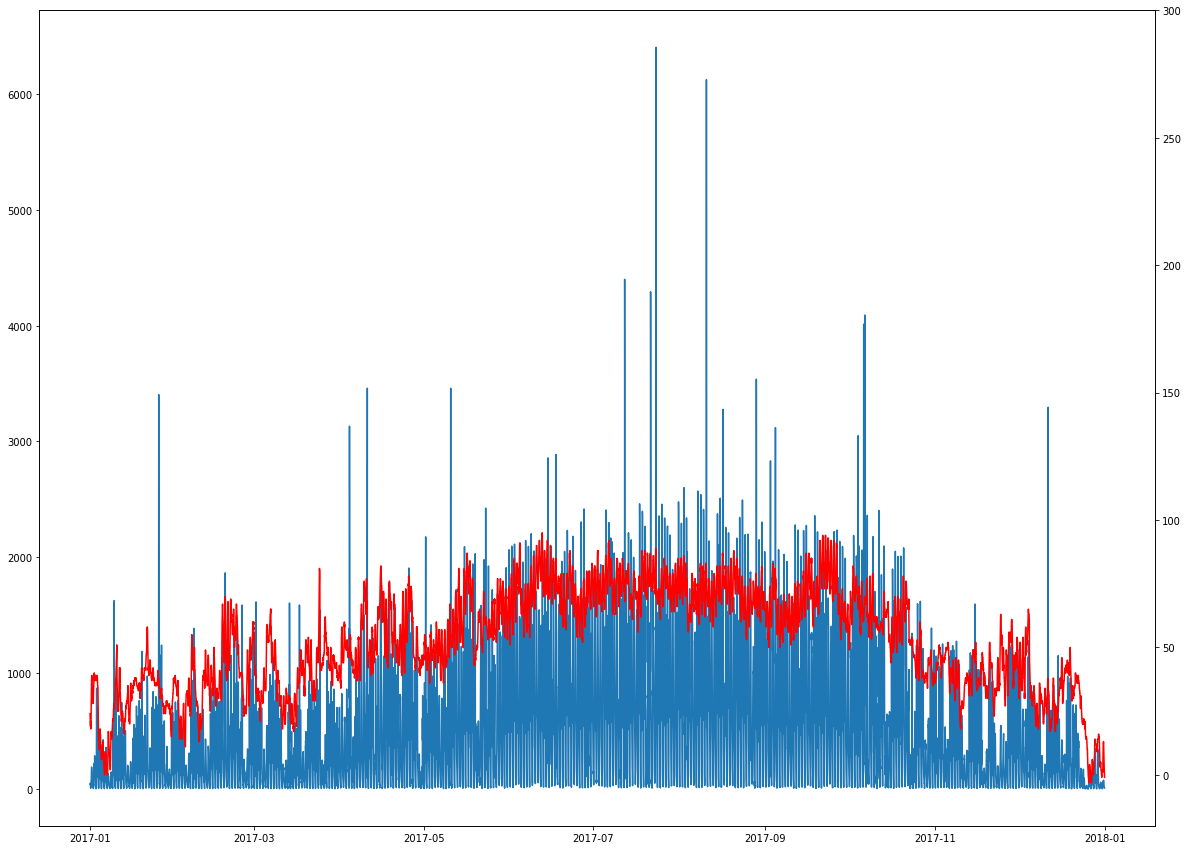

In [4]:
datagroup = data.groupby(['datetime','temp'], as_index = False)[['trips']].sum()
hourlyrides17 = datagroup[datagroup['datetime'].dt.year > 2016].sort_values('datetime')

fig, ax1 = plt.subplots(figsize = (20,15))
ax1.plot(hourlyrides17['datetime'] , hourlyrides17['trips'])

ax2 = ax1.twinx()
ax2.plot(hourlyrides17['datetime'] , hourlyrides17['temp'], color = 'r')
ax2.set_ylim([-20,300]);

## 1.2 Add Event Data

In [15]:
sportsdata = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/sporteventdata.pkl')

In [16]:
sportsdata.shape

(1298, 6)

In [17]:
sportsdata.head()

,attend,datetime,games,location,team,gpslocation
1,NaN,2013-10-31 19:00:00,2,unitedcenter,bulls,"41.8749965, -87.671163982"
4,NaN,2013-11-08 19:00:00,5,unitedcenter,bulls,"41.8749965, -87.671163982"
5,NaN,2013-11-11 19:00:00,6,unitedcenter,bulls,"41.8749965, -87.671163982"
7,NaN,2013-11-16 19:00:00,8,unitedcenter,bulls,"41.8749965, -87.671163982"
8,NaN,2013-11-18 19:00:00,9,unitedcenter,bulls,"41.8749965, -87.671163982"


In [18]:
sportsdatahourminus1 = sportsdata.copy(deep = True)
sportsdatahourminus1['datetime'] = sportsdatahourminus1['datetime'] + pd.DateOffset(hours = -1)
sportsdatahouradd1 = sportsdata.copy(deep = True)
sportsdatahouradd1['datetime'] = sportsdatahouradd1['datetime'] + pd.DateOffset(hours = 1)
sportsdatafull = pd.concat([sportsdata, sportsdatahourminus1, sportsdatahouradd1])
sportsdatafull.columns = ['attend','datetime','games','location','event','gpslocation']

In [19]:
sportsdatafull.sort_values('datetime')

,attend,datetime,games,location,event,gpslocation
0,39012,2013-04-01 12:00:00,1,uscellular,sox,"41.824663368, -87.633664132"
0,39012,2013-04-01 13:00:00,1,uscellular,sox,"41.824663368, -87.633664132"
0,39012,2013-04-01 14:00:00,1,uscellular,sox,"41.824663368, -87.633664132"
1,14213,2013-04-03 12:00:00,2,uscellular,sox,"41.824663368, -87.633664132"
1,14213,2013-04-03 13:00:00,2,uscellular,sox,"41.824663368, -87.633664132"
1,14213,2013-04-03 14:00:00,2,uscellular,sox,"41.824663368, -87.633664132"
2,15036,2013-04-04 12:00:00,3,uscellular,sox,"41.824663368, -87.633664132"
2,15036,2013-04-04 13:00:00,3,uscellular,sox,"41.824663368, -87.633664132"
2,15036,2013-04-04 14:00:00,3,uscellular,sox,"41.824663368, -87.633664132"
3,15312,2013-04-05 18:00:00,4,uscellular,sox,"41.824663368, -87.633664132"


In [20]:
manualevents = pd.read_csv('/home/michael/Documents/Projects/divvydataproject/data/EventsManualList.csv')

In [21]:
manualevents['Location'] = manualevents['Location'].str.lower()
manualevents['datetimeraw'] = manualevents['Date'] + ' ' + manualevents['Time']
manualevents['datetime'] = pd.to_datetime(manualevents['datetimeraw']).dt.round('H')

In [22]:
manualcubsplayoffs = manualevents[manualevents['Event'] == 'cubs']
manualcubsplayoffsminus1 = manualcubsplayoffs.copy(deep = True)
manualcubsplayoffsminus1['datetime'] = manualcubsplayoffsminus1['datetime'] + pd.DateOffset(hours = -1)
manualcubsplayoffsadd1 = manualcubsplayoffs.copy(deep = True)
manualcubsplayoffsadd1['datetime'] = manualcubsplayoffsadd1['datetime'] + pd.DateOffset(hours = 1)
manualcubsplayoffsfull = pd.concat([manualcubsplayoffs, manualcubsplayoffsminus1, manualcubsplayoffsadd1])

In [23]:
festivaleventsorig = manualevents[manualevents['Event'] != 'cubs'].copy(deep = True)
festivalevents = festivaleventsorig.copy(deep = True)
festivaleventsfull = pd.DataFrame()
for hour in range(0,9):
    festivalevents['datetime'] = festivaleventsorig['datetime'] + pd.DateOffset(hours = hour)
    festivaleventsfull = festivaleventsfull.append(festivalevents)

In [24]:
manualeventsfull = pd.concat([manualcubsplayoffsfull,festivaleventsfull])
manualeventsfull = manualeventsfull[['Event','Location','datetime']]
manualeventsfull.columns = ['event','location','datetime']
eventsfull = pd.concat([sportsdatafull,manualeventsfull])
eventsfull = eventsfull[['event','location','datetime']]

In [25]:
eventsfull['location'] = np.where(eventsfull['location'] == 'p24','grantpark', eventsfull['location'])
eventsfull['location'] = np.where(eventsfull['location'] == 'p210','unionpark', eventsfull['location'])

In [26]:
disttable = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/distancetable.pkl')
disttable = disttable[(disttable['distance'] != 0) & (disttable['fid'].str.slice(0,1) != 'p')]

In [27]:
disttable = disttable.sort_values('distance', ascending = True)
disttabletop = disttable.groupby(['tid']).head(3)

In [28]:
eventloc = pd.merge(eventsfull, disttabletop, how = 'left', left_on = 'location', right_on = 'tid')
eventloc = eventloc[['datetime','fid','location','event']]
eventloc.columns = ['datetime','to_station_id','location','event']
eventloc = pd.get_dummies(eventloc, columns = ['event'])

In [29]:
eventloc.groupby(['location','to_station_id'],as_index = False)[['datetime']].count()

,location,to_station_id,datetime
0,grantpark,2,153
1,grantpark,45,153
2,grantpark,623,153
3,soldierfield,4,120
4,soldierfield,338,120
5,soldierfield,370,120
6,unionpark,88,135
7,unionpark,119,135
8,unionpark,346,135
9,unitedcenter,122,1344


In [30]:
eventloc.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/eventlocations.pkl')

In [2]:
data = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/rideweatheragg.pkl')
data = data[data['stationid'] == 119]

In [3]:
data.shape

(43289, 7)

In [4]:
eventloc = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/eventlocations.pkl')

In [5]:
fulldata = pd.merge(data, eventloc, how = 'left', left_on = ['datetime','stationid'], right_on = ['datetime','to_station_id'])
del data

In [6]:
fulldata.shape

(43289, 16)

In [7]:
fulldata = fulldata.fillna(0)

In [8]:
fulldata['date'] = fulldata['datetime'].dt.date
fulldata['hour'] = fulldata['datetime'].dt.hour

In [10]:
fulldata.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/workingaggfile.pkl')
fulldata.shape

MemoryError: 

In [9]:
stationdaymax = fulldata.groupby(['date','stationid'],as_index = False)[['outgoing','incoming']].max()
stationdaymax.columns = ['date','stationid','maxout','maxin']

In [10]:
fulldata = pd.merge(fulldata,stationdaymax , how = 'inner', 
                left_on = ['date','stationid'], right_on = ['date','stationid'])

In [11]:
fulldata = fulldata.drop(['to_station_id','location'],axis = 1)

## 4.4 Station Information

In [12]:
stations = pd.read_pickle('/home/michael/Documents/Projects/divvydataproject/data/stations.pkl')

In [13]:
stations.head()

,id,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7
0,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,6/10/2013 10:43,NaN
1,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,6/10/2013 10:44,NaN
2,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,6/10/2013 10:46,NaN
3,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,6/10/2013 10:46,NaN
4,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,6/10/2013 11:18,NaN


In [14]:
stations.columns = ['stationid','name','city','lat','long','capacity','onlinedate','x']
fulldata = pd.merge(fulldata, stations[['stationid','name','lat','long','capacity','onlinedate']], how = 'inner')

In [15]:
fulldata.dtypes

datetime              datetime64[ns]
stationid                      int64
temp                         float64
precip                       float64
incoming                     float64
outgoing                     float64
net                          float64
event_bears                  float64
event_blackhawks             float64
event_bulls                  float64
event_cubs                   float64
event_lollapalooza           float64
event_pitchfork              float64
event_sox                    float64
date                          object
hour                           int64
maxout                       float64
maxin                        float64
name                          object
lat                          float64
long                         float64
capacity                       int64
onlinedate                    object
dtype: object

In [16]:
fulldata['onlinedate'] = pd.to_datetime(fulldata['onlinedate'])
fulldata = fulldata[fulldata['datetime'] >= fulldata['onlinedate']]

In [17]:
fulldata.head()

,datetime,stationid,temp,precip,incoming,outgoing,net,event_bears,event_blackhawks,event_bulls,...,event_sox,date,hour,maxout,maxin,name,lat,long,capacity,onlinedate
0,2013-08-01 16:00:00,119,78.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2013-08-01,16,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
1,2013-08-01 00:00:00,119,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2013-08-01,0,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
2,2013-08-01 01:00:00,119,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2013-08-01,1,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
3,2013-08-01 02:00:00,119,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2013-08-01,2,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
4,2013-08-01 03:00:00,119,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2013-08-01,3,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00


In [58]:
fulldata.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/fulldataagg.pkl')

In [19]:
pitchfork = fulldata[fulldata['stationid'] == 119]
pitchfork.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/pitchfulldataagg.pkl')

## Wrigley Test

In [15]:
wrigleystations = [114, 165, 304, 240, 256]
wrigley = data[data['to_station_id'].isin(wrigleystations[1:])]

In [16]:
wrigley.sort_values('trips',ascending = False)

,datetime,to_station_id,temp,precip,trips
55181,2013-08-18 17:00:00,165,79.0,0.0,28.0
1705857,2015-07-11 14:00:00,304,77.0,0.0,26.0
382649,2014-07-18 19:00:00,165,74.0,0.0,25.0
622344,2014-08-08 14:00:00,165,81.0,0.0,23.0
1979851,2015-09-05 12:00:00,165,80.0,0.0,21.0
3467219,2016-10-29 12:00:00,165,70.0,0.0,21.0
1916262,2015-08-22 14:00:00,304,79.0,0.0,20.0
988755,2014-06-26 18:00:00,165,67.0,0.0,20.0
561791,2014-09-20 11:00:00,165,77.0,0.0,20.0
1634444,2015-05-16 14:00:00,304,77.0,0.0,19.0


In [14]:
wrigley.groupby(['to_station_id','datetime'], as_index = False)[['trips']].max().sort_values('trips', ascending = False)

,to_station_id,datetime,trips
32675,114,2016-10-15 18:00:00,65.0
31955,114,2016-09-15 18:00:00,60.0
40421,114,2017-09-03 12:00:00,56.0
38958,114,2017-07-04 13:00:00,51.0
32843,114,2016-10-22 18:00:00,51.0
24055,114,2015-10-20 18:00:00,48.0
24079,114,2015-10-21 18:00:00,48.0
29909,114,2016-06-21 18:00:00,47.0
32484,114,2016-10-07 19:00:00,46.0
41286,114,2017-10-09 14:00:00,46.0
